**Assignment # 2, CNN over Fasion MNIST**

In this assignment you are requested to build a convolutional network and train it over the Fasion MNIST data, which is a collection of 28X28 back and white images, classified into 10 different classes of clothing items. For more information about Fashion MNIST you may refer to: 
https://github.com/zalandoresearch/fashion-mnist 

In [ ]:
# Loading Fashion MNIST


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple
import time

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Use dataloaders for train and test (batch size is 4)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [ ]:
# The images are of 1, 28, 28 size (only one black-white channel)

trainset[0][0].shape

torch.Size([1, 28, 28])

# **Part 1**: Implementing a CNN network for Fashion MNIST
Here is what you need to do; you are encoureged to look at notebook "DL Notebook 9 - CIFAR CNN" when trying to complete the next steps.


Write a network CNNFMnist, that has the following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

In [ ]:
class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)        
        self.conv2 = nn.Conv2d(10, 5, 3)        
        self.conv3 = nn.Conv2d(5, 16, 3)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        features_number = 1
        for i in size:
            features_number *= i
        return features_number

Write a code that trains the network with FashionMNIST train dataset, for classification (use cross entropy, and SGD).
Run the network for at least 10 epochs, over the entire dataset. Make sure to print the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training. 

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set). You are encoureged to write a different function for claculating the loss of the test set, and then call it from the training procedure.


You should collect the loss values in an array, so you can plot then into two curves, one for train and one for test.

In addition, you should measure the time it takes you to train the network completely.



Write a function that evaluates the resulted model over the entire test data of FashionMNIST. Provide a single accuracy number.

In [ ]:
def calc_test_loss(neural_net, criterion, testloader, cuda=False):
  with torch.no_grad():
    loss = 0.0
    for inputs, labels in testloader:
      
      if cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
      
      outputs = neural_net(inputs)

      # Handle transfer network which returns part of network
      if 2 == len(outputs):
        outputs = outputs[0]

      loss += criterion(outputs, labels).item()
    
    print('loss of test: %.3f' %(loss / len(testloader))) 
    return loss / len(testloader)

In [ ]:
TrainRes = namedtuple('TrainRes', ['time', 'model', 'train_loss', 'train_loss_per_epoch', 'test_loss', 'averaging_size'])

In [ ]:
def model_train(neural_net, trainloader=trainloader, test_calc=True, testloader=testloader, cuda=False, epochs=10, averaging_size=1000):
  
  train_loss = []
  train_loss_per_epoch = []
  test_loss = []
  start = time.time()
  neural_net = neural_net.cuda() if cuda else neural_net.cpu()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.001, momentum=0.9)
 

  for epoch in range(epochs):  
      acum_loss = 0.0
      cur_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()

      # zero the parameter gradients
          optimizer.zero_grad()
      # forward + backward + optimizing
          outputs = neural_net(inputs)
          if 2 == len(outputs):
            outputs = outputs[0]
      # print statistics and add average train and test loss of epoch to list
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          acum_loss += loss.item()
          cur_loss += loss.item()
          if (i+1) % averaging_size == 0:    
              print('[%d, %5d] current loss: %.3f' %(epoch + 1, i + 1, acum_loss / averaging_size))
              train_loss.append(acum_loss / averaging_size)
              acum_loss = 0.0

      train_loss_per_epoch.append(cur_loss)
      
      if test_calc is True and testloader is not None:
        test_loss.append(calc_test_loss(neural_net, criterion, testloader, cuda)) 
  finish = time.time()
  return TrainRes(finish - start, neural_net, train_loss, train_loss_per_epoch, test_loss, averaging_size)

In [ ]:
run_CPU = model_train(neural_net=CNNFMnist(), cuda=False, epochs=10, averaging_size=1000)
print(f"model training lasted {run_CPU.time} seconds; CPU accuracy on test images : {accuracy(run_CPU.model, False)} %")

[1,  1000] current loss: 2.288
[1,  2000] current loss: 1.288
[1,  3000] current loss: 0.881
[1,  4000] current loss: 0.788
[1,  5000] current loss: 0.727
[1,  6000] current loss: 0.659
[1,  7000] current loss: 0.648
[1,  8000] current loss: 0.617
[1,  9000] current loss: 0.587
[1, 10000] current loss: 0.607
[1, 11000] current loss: 0.576
[1, 12000] current loss: 0.530
[1, 13000] current loss: 0.521
[1, 14000] current loss: 0.528
[1, 15000] current loss: 0.518
loss of test: 0.508
[2,  1000] current loss: 0.503
[2,  2000] current loss: 0.479
[2,  3000] current loss: 0.494
[2,  4000] current loss: 0.474
[2,  5000] current loss: 0.473
[2,  6000] current loss: 0.462
[2,  7000] current loss: 0.433
[2,  8000] current loss: 0.454
[2,  9000] current loss: 0.450
[2, 10000] current loss: 0.425
[2, 11000] current loss: 0.426
[2, 12000] current loss: 0.424
[2, 13000] current loss: 0.440
[2, 14000] current loss: 0.423
[2, 15000] current loss: 0.411
loss of test: 0.409
[3,  1000] current loss: 0.393

In [ ]:
def plot_model(train_result, trainloader=trainloader, plot_test=True):
  plt.figure(figsize=(11,7))
  plt.plot(range(1, len(train_result.train_loss_per_epoch) + 1), [x / len(trainloader) for x in train_result.train_loss_per_epoch], 'b', label='train loss per epoch')
  if plot_test is True:
    plt.plot(range(1, len(train_result.test_loss) + 1), train_result.test_loss, 'r', label='test loss per epoch')
  plt.xlabel("Number of epoch")
  plt.ylabel("Cross Entropy Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def accuracy(neural_net, cuda=False):
  bullseye = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          
          if cuda:
            images = images.cuda()
            labels = labels.cuda()   
          outputs = neural_net(images)
          _, predict = torch.max(outputs.data, 1)
          total += labels.size(0)
          bullseye += (predict == labels).sum().item()

  return 100 * bullseye / total

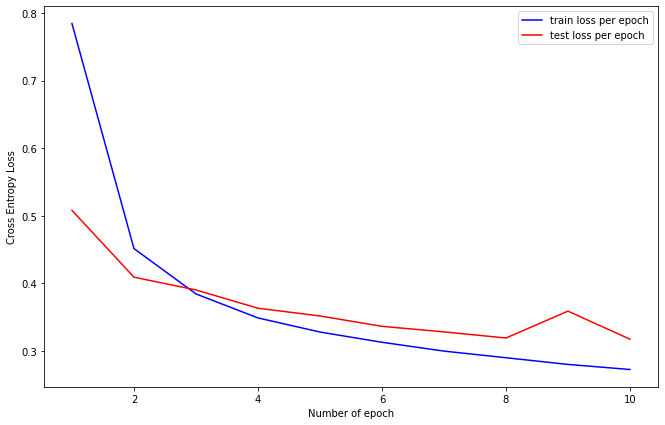

In [ ]:
plot_model(run_CPU)

# **Part 2**: Training with a GPU 
You are requested to change your code to use the GPU instead of the CPU.
This can be easily done bu converting every torch.tensor to torch.cuda.tensor. 

Specific instructions:
* Change the hardware equipent of your colab notebook. To do that, go to the "Runtime" menu, and then to "Change runtime type". In the dialog box, change "Hardware accelerator" to GPU.
* Please follow the lines that were commented out with the comment    # -- For GPU
* Also, remove the lines that have the comment # -- For CPU

Train your network again and compare training time.

In [ ]:
run_GPU = model_train(neural_net=CNNFMnist(),cuda=True, epochs=10, averaging_size=1000)
print(f"model training lasted {run_GPU.time} seconds; accuracy on test images : {accuracy(run_GPU.model, True)}%")

[1,  1000] current loss: 2.303
[1,  2000] current loss: 2.299
[1,  3000] current loss: 2.098
[1,  4000] current loss: 0.987
[1,  5000] current loss: 0.755
[1,  6000] current loss: 0.727
[1,  7000] current loss: 0.648
[1,  8000] current loss: 0.606
[1,  9000] current loss: 0.595
[1, 10000] current loss: 0.564
[1, 11000] current loss: 0.571
[1, 12000] current loss: 0.535
[1, 13000] current loss: 0.538
[1, 14000] current loss: 0.528
[1, 15000] current loss: 0.485
loss of test: 0.514
[2,  1000] current loss: 0.479
[2,  2000] current loss: 0.473
[2,  3000] current loss: 0.485
[2,  4000] current loss: 0.459
[2,  5000] current loss: 0.438
[2,  6000] current loss: 0.446
[2,  7000] current loss: 0.459
[2,  8000] current loss: 0.449
[2,  9000] current loss: 0.410
[2, 10000] current loss: 0.439
[2, 11000] current loss: 0.418
[2, 12000] current loss: 0.411
[2, 13000] current loss: 0.424
[2, 14000] current loss: 0.418
[2, 15000] current loss: 0.421
loss of test: 0.414
[3,  1000] current loss: 0.419

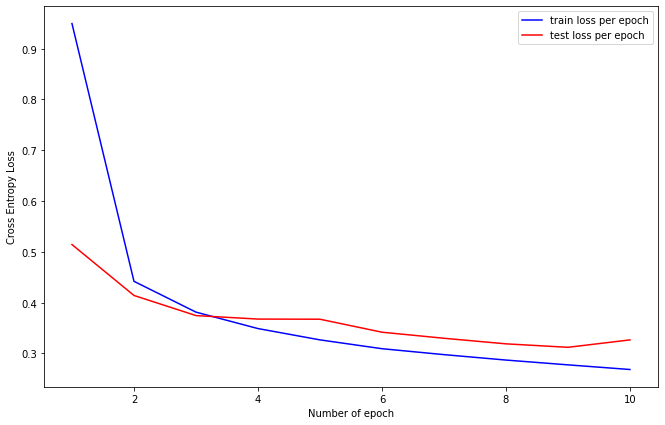

In [ ]:
plot_model(run_GPU)

# **Part 3**: Transfer Learning
Training data is a valuable resource, and sometimes there is not enough of it for training a neural netowrk at scale. To handle this situation, one approach is transfer learning, where we train our network on a different related task, and then switch to train it on the downstream task that we focus on. In this last part of the assignment, you are requested to pretrain your network on CIFAR-10, then train it on Fashion-MNIST, and measure its contribution to the results. To do that, please follow the steps:

**Step 1**

Modify your CNNFMnist implementation to return the output of the layer one before last after Relu (Linear layer of size 64, above) in addition to the final output. For example:

```
def forward(self, x):
  ...
  return h, out
```

 and train it on the training-set part of CIFAR-10. Use batch size of 4, and train it for at least 10 epochs. Note that CIFAR-10 images are of different shapes (3X32X32), therefore a conversion into 1X28X28 is needed. To do that, when you load CIFAR-10 using a torchvision Dataset, you can use the transformer torchvision.transforms.Grayscale(num_output_channels=1) in order to convert the images to a 1X32X32 grayscale volume:

```
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor()]))
```
Then, from each 1X32X32 image, sample 10 1X28X28 images at random positions, and use them for training (*optional* - for data augmentation, if you want, you can also generate the reflection of each of the 10 images and add them the training set).

**Setp 2**

Once done, write a new Module CNNFMnist2, which uses CNNFMnist as one of its sub modules, followed by some additional layers. The output of CNNFMnist that goes into the next layer, should be the output of the 64 neuron one-before-last layer, as described above. CNNFMnist2 should have the following architecture:

* CNNFMnist
* Liner, output size 32
* Relu
* Liner, output size 16
* Relu
* Liner, output size 10

Make sure to allow the user to assign a pre-trained version CNNFMnist as a member of the module. For example:

```
class CNNFMnist2(nn.Module):
    def __init__(self, trained_cnnfmnist_model):
        super(CNNFMnist2, self).__init__()
        self.trained_cnnfmnist_model = trained_cnnfmnist_model
        self.fc1 = nn.Linear(64, 32)
        ...
```

**Step 3**

Train and eval CNNFMnist2 on Fashion-MNIST a few times:
- Using the pre-trained version of CNNFMnist.
- Using a fresh CNNFMnist instance (without training it).
- (Optional) Using the pre-trained version of CNNFMnist, after freezing its weights using the .eval() function.

Report on evaluation results (accuracy) for all of those cases.

In [ ]:
# STEP 1 #
class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)        
        self.conv2 = nn.Conv2d(10, 5, 3)        
        self.conv3 = nn.Conv2d(5, 16, 3)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = x
        x = self.fc3(x)
        return x, y
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        features_number = 1
        for i in size:
            features_number *= i
        return features_number

In [ ]:
class CIFAR10shrink(torch.utils.data.Dataset):
  def __init__(self, train=True):

    transformer = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                                  torchvision.transforms.TenCrop(28),
                                                  torchvision.transforms.Lambda(lambda crops: torch.stack([torchvision.transforms.ToTensor()(crop) for crop in crops]))])

    # Converting to grayscale createing 10 28x28 crops of each image
    cifar10 = torchvision.datasets.CIFAR10(root='./data', train=train, download=True, transform=transformer)

    self.data = []
    for input, label in cifar10:
      for image in input:
        self.data.append((image, label))

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)

In [ ]:
cifar_new_trainset = CIFAR10shrink()
cifar_new_trainloader = torch.utils.data.DataLoader(cifar_new_trainset, batch_size=4, shuffle=True)

Extracting ./data/cifar-10-python.tar.gz to ./data



In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
cifar_new_testset = CIFAR10shrink(train=False)
cifar_new_testloader = torch.utils.data.DataLoader(cifar_new_testset, batch_size=4,
                                                 shuffle=False)

Files already downloaded and verified


In [ ]:
cifar_run_GPU = model_train(neural_net=CNNFMnist(), trainloader=cifar_new_trainloader, test_calc=True, testloader=cifar_new_testloader,cuda=True, epochs=10, averaging_size=10000)
pretrain_CNNFMnist = cifar_run_GPU.model
print(f"model training lasted {cifar_run_GPU.time} seconds")

[1, 10000] current loss: 2.271
[1, 20000] current loss: 1.998
[1, 30000] current loss: 1.788
[1, 40000] current loss: 1.713
[1, 50000] current loss: 1.672
[1, 60000] current loss: 1.633
[1, 70000] current loss: 1.599
[1, 80000] current loss: 1.571
[1, 90000] current loss: 1.537
[1, 100000] current loss: 1.518
[1, 110000] current loss: 1.495
[1, 120000] current loss: 1.474
loss of test: 1.456
[2, 10000] current loss: 1.445
[2, 20000] current loss: 1.428
[2, 30000] current loss: 1.404
[2, 40000] current loss: 1.398
[2, 50000] current loss: 1.391
[2, 60000] current loss: 1.386
[2, 70000] current loss: 1.373
[2, 80000] current loss: 1.369
[2, 90000] current loss: 1.367
[2, 100000] current loss: 1.348
[2, 110000] current loss: 1.339
[2, 120000] current loss: 1.346
loss of test: 1.343
[3, 10000] current loss: 1.322
[3, 20000] current loss: 1.310
[3, 30000] current loss: 1.310
[3, 40000] current loss: 1.309
[3, 50000] current loss: 1.303
[3, 60000] current loss: 1.300
[3, 70000] current loss:

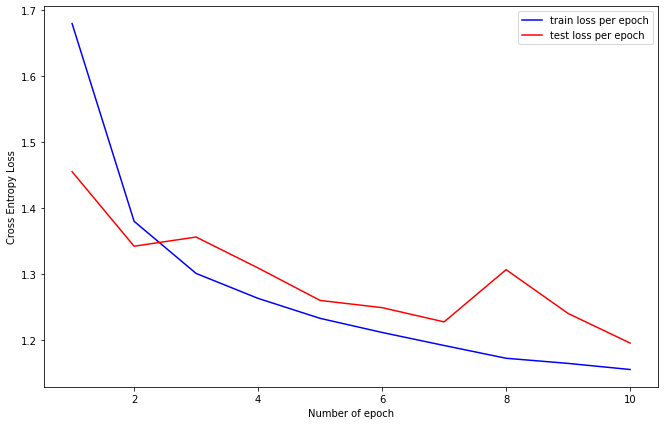

In [ ]:
plot_model(cifar_run_GPU, trainloader=cifar_new_trainloader, plot_test=True)

In [ ]:
# STEP 2 #
class CNNFMnist2(nn.Module):
    def __init__(self, trained_cnnfmnist_model=None):
        super(CNNFMnist2, self).__init__()
        if trained_cnnfmnist_model is None:
          self.trained_cnnfmnist_model = CNNFMnist()
        else:
          self.trained_cnnfmnist_model = trained_cnnfmnist_model
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):

      # Pass input through trained_cnnfmnist_model upto linear with output 64
      _, x = self.trained_cnnfmnist_model.forward(x)

      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
# STEP 3 #
pretrain_run_GPU = model_train(neural_net=CNNFMnist2(pretrain_CNNFMnist),cuda=True, epochs=10, averaging_size=1000)
print(f"Model training lasted {pretrain_run_GPU.time} seconds; accuracy on test images : {accuracy(pretrain_run_GPU.model, True)}")

[1,  1000] current loss: 1.316
[1,  2000] current loss: 0.750
[1,  3000] current loss: 0.631
[1,  4000] current loss: 0.595
[1,  5000] current loss: 0.521
[1,  6000] current loss: 0.524
[1,  7000] current loss: 0.507
[1,  8000] current loss: 0.477
[1,  9000] current loss: 0.479
[1, 10000] current loss: 0.447
[1, 11000] current loss: 0.473
[1, 12000] current loss: 0.456
[1, 13000] current loss: 0.435
[1, 14000] current loss: 0.451
[1, 15000] current loss: 0.441
loss of test: 0.446
[2,  1000] current loss: 0.421
[2,  2000] current loss: 0.407
[2,  3000] current loss: 0.405
[2,  4000] current loss: 0.423
[2,  5000] current loss: 0.396
[2,  6000] current loss: 0.418
[2,  7000] current loss: 0.378
[2,  8000] current loss: 0.376
[2,  9000] current loss: 0.385
[2, 10000] current loss: 0.411
[2, 11000] current loss: 0.386
[2, 12000] current loss: 0.402
[2, 13000] current loss: 0.379
[2, 14000] current loss: 0.392
[2, 15000] current loss: 0.371
loss of test: 0.416
[3,  1000] current loss: 0.364

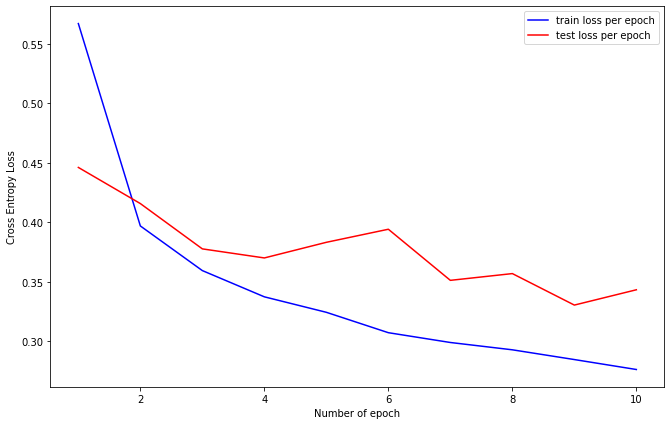

In [ ]:
plot_model(pretrain_run_GPU)

In [ ]:
fresh_run_GPU = model_train(neural_net=CNNFMnist2(), cuda=True, epochs=10, averaging_size=1000)
print(f"Model training lasted {fresh_run_GPU.time} seconds; accuracy on test images : {accuracy(fresh_run_GPU.model, True)}")

[1,  1000] current loss: 2.308
[1,  2000] current loss: 2.305
[1,  3000] current loss: 2.302
[1,  4000] current loss: 2.303
[1,  5000] current loss: 2.303
[1,  6000] current loss: 2.303
[1,  7000] current loss: 2.303
[1,  8000] current loss: 2.301
[1,  9000] current loss: 2.298
[1, 10000] current loss: 2.079
[1, 11000] current loss: 1.334
[1, 12000] current loss: 1.119
[1, 13000] current loss: 0.998
[1, 14000] current loss: 0.869
[1, 15000] current loss: 0.798
loss of test: 0.765
[2,  1000] current loss: 0.773
[2,  2000] current loss: 0.697
[2,  3000] current loss: 0.666
[2,  4000] current loss: 0.658
[2,  5000] current loss: 0.638
[2,  6000] current loss: 0.623
[2,  7000] current loss: 0.584
[2,  8000] current loss: 0.607
[2,  9000] current loss: 0.596
[2, 10000] current loss: 0.541
[2, 11000] current loss: 0.544
[2, 12000] current loss: 0.537
[2, 13000] current loss: 0.536
[2, 14000] current loss: 0.534
[2, 15000] current loss: 0.535
loss of test: 0.514
[3,  1000] current loss: 0.500

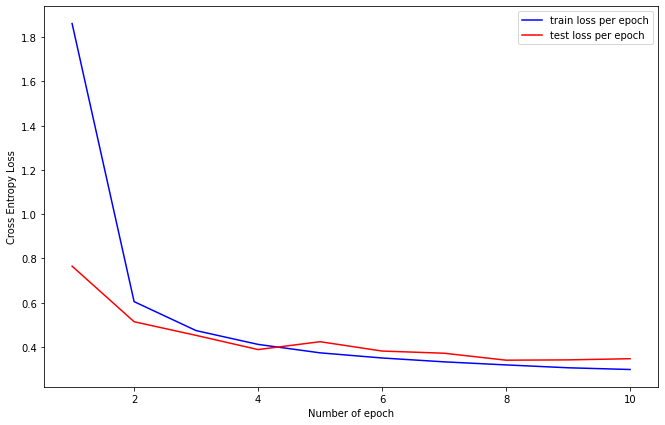

In [ ]:
plot_model(fresh_run_GPU)

# Submission instructions

You should submit a pdf file with the following items:

CPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

GPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

Transfer Learning Experiment:
* Accuracy results on test set for the 2-3 implemeted settings (see above)

Link for your collab notebook.
ID and names of submitters.


Good luck!